<a href="https://colab.research.google.com/github/nifaullah/NLP-Analysis-Sentiment-Classifcation-on-568K-Amazon-Fine-Food-Reviews/blob/master/NLP_Analysis_%26_Sentiment_Classifcation_on_568K%2B_Amazon_Fine_Food_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  NLP Analysis & Sentiment Classification on 568K+ Amazon Fine Food Reviews 


**Dataset:**

Amazon Fine Food Reviews dataset is downloaded from [Kaggle](https://https://www.kaggle.com/snap/amazon-fine-food-reviews) and placed in my google drive for programmatic retrieval. It consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,000. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. You can read more about the data at [SNAP](https://snap.stanford.edu/data/web-FineFoods.html).

**Approach:**

Many a time in business, as well as in academia, we don't have the luxury of proper data pipelines to decide the scope and the value associated with data beforehand, and often we derive value out of already collected, sometimes good but often messy, data. That was the case for this analysis, and that is why you'd find the Goal of the project in section 3. 

An analysis is a sequential process, which involves a lot of questions back and forth. I've tried to capture this natural question and answer process by appropriately documenting the question and the answer to the question either through text or through python commands. 

I think this approach at least serves two purposes first it gives me an option to analyze my thinking, to see what kind of question I am asking and to track my approach to a problem. Secondly, some times when we read someone else's analysis we find it too hard to decipher some of their actions, this is an intuitive way where the question precedes an action, thereby self-explaining the action at each step. I've tried to keep the questions as natural as possible. 

Sometimes 4 or 5 questions into some section of the analysis you may feel I could've skipped questions 1, 2 & 3 and reached straight to questions 4 & 5 but when we do analysis it seldom happens that you reach straight to the goal, it is often preceded by some missteps or extra steps before where we eventually reach where we reach, and I am attempting to document those missteps and extra steps. 

I would love for you to read the analysis in its entirety, but it is possible that you may feel that the analysis is too lengthy and that you may not have enough time to go through the entire analysis. If that's case I would strongly suggest you atleast read the summary part( section 9.1). 

**Key Results:**

1. Model finalized was a RNN model (LSTM Cells).
2. Model had an initial train and validation accuracy of 90%.
3. Model had Sensitivity of 91.44%, Specificity of 93.56% and precision equal to 98.06%.
4. Upon detailed analysis of the errors, model accuracy and learning was found to be higher than the earlier assessment. 
5. Model is close to the desired Low Bias Low Variance sub-section.
6. Learned weights can be successfully used to learn sentiments for similar tasks in different problem areas through transfer learning.
7. RNN Architecture (including the LSTM cell) is extremely powerful at dealing with sequence learning problems, especially more so when it comes to Natural Language Processing.

#1. Initial Setup

##1.1 Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec, KeyedVectors
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Embedding
from tensorflow.keras.callbacks import TensorBoard
import time
from random import sample
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

##1.2 Data

In [0]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv("drive/My Drive/colab_files/Amazon_Reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. EDA

**2.1 Question:** How many unique values ?

In [0]:
df.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

**2.2 Question:** Are there any null values ?

In [0]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

**2.3 Question:** How the scores are distributed ? 

From the below plots the dataset is heavily skewed towards positive rating, this has to be kept in mind before any assertions are drawn.

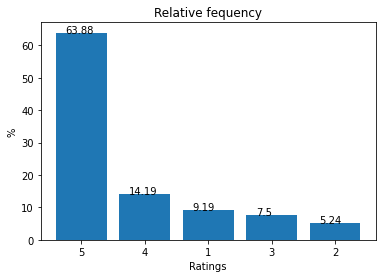

In [0]:
def GetRelativeFrequency(df):
  series = df.Score.value_counts() / len(df)
  indx = np.sort(df.Score.unique())
  plt.bar(indx, series*100)
  plt.ylabel('%')
  plt.xlabel('Ratings')
  plt.title('Relative fequency')
  plt.xticks(indx, series.index)
  for i, v in enumerate(series*100):
      plt.text(indx[i] - 0.25, v + 0.01, str(round(v,2)))
GetRelativeFrequency(df)

# 3. What is the Goal of this project?

Given that the dataset has very limited features the scope of the analysis is severely restricted. More details about the user (like the users demographic) would have opened doors for all kinds of analysis, but still the textual data present can be used to develop a sentiment detector or classifier.

I'd like to build a classifier which uses the whole review to classify the sentiments broadly into 2 categories Positive(4,5) and Negative(1,2,3), afterward ideally I'd like to test this upon food reviews in twitter where there're no ratings accompanying text, but let's condition this upon the availability of data.  Further, I also, if time permits, would like to add more granularity to classification task but I believe this will reduce the practical implementation as it will needlessly shrink the generality of the classifier thereby messing up the practicality aspect.

Further, I'd like to analyze in general what are the type of phrases or words that make a review positive or negative and check if this reconciles with our understanding of language.

# 4. Data Preparation

**Question 4.1:** is the data balanced? if not do you want to artificially balance?

No, the data has severe imbalance towards the positive review. For ideal results and for the ability to give the model a honest chance to learn things, input classes should be appropriately weighted, otherwise the model would find it easy and beneficial for itself to classify all things postive.

**Question 4.2:** What approach do I want to take balance data ?

For now lets proceed with weighted loss function where I'll weigh the loss function such that classifier classfies both the sentiments with equal effect.

**Question 4.3:** Does the data needs to be prepared or preprocessed before it is fed to the model ?

Yes.

In [0]:
#Cleaning Text column by lowering all the text and removing all html tags and punctuations
def CleanText(series):
    series = series.str.lower()
    #Removing html tags
    series = series.apply(lambda x: re.compile(r'<[^>]+>').sub('', str(x)))
    #Removing Punctuations
    series = series.str.replace('[^a-zA-Z ]', '')
    return series

df.Text = CleanText(df.Text)

**Question 4.3.1:** Are the texts cleaned correctly ?

In [0]:
df.Text[55555]

'what do you get when you combing cheerios with honey smacks and peanuts you get this  and it actually sounds good unfortunately the combination of the flavors is just okay not great and im not sure it is even good there is a weird cloying aftertaste and the cereal feels too dry the individual pieces too large and too crunchy it just wasnt for me the kidlets think it is okay but prefer honey nut cheerios or even raisin bran my fave to this  and thats not a good signbottom line ymmv but i wont be replacing this box with another one'

**Question 4.3.2:** Why all words from all of the reviews are put into a list ?

Because the Gensim Word2Vec function takes words as a list.

In [0]:
#Creating Vocabulary & Word Embeddings using 
words = [i.split() for i in df.Text.values]

**Question 4.3.3:** Why do we need word embeddings?

Word embeddings are word vectors with n dimensions, i.e. mapppings of all uniuqe words in a n-dimensional space. Using this mapping we can find similarity and dissimilarity between the words across the dimensions. Word embedding adds the much required context to each words, therfore immensely useful for Natural Language Processing tasks. Without word embeddings all the vectors are one hot encoded vectors thus containing no information about relation between words.

In [0]:
w2v = Word2Vec(words, min_count =1, size=300)

**Question 4.3.4:** What does the Word2Vec object look like ?

In [0]:
",".join(w2v.wv.__dict__.keys())

'vectors,vocab,vector_size,index2word,vectors_norm'

**Question 4.3.5:** Are the dimensions of the word embeddings as expected (i.e = 300) ?

In [0]:
w2v.wv.vectors.shape

(307893, 300)

**Question 4.3.6:** Are the index & words mapped correctly to each other ?

In [0]:
print(w2v.wv.index2word[542])
print(w2v.wv.vocab['cannot'].index)

cannot
542


**Question 4.3.7:** What does a weight look like ?

In [0]:
print(w2v.wv.vectors[10,:].shape)
w2v.wv.vectors[10,:]

(300,)


array([-0.18104742, -1.2497998 , -1.1319817 ,  1.8067105 ,  2.7872844 ,
       -2.010245  ,  0.3808805 ,  1.1534877 , -2.4066968 ,  0.32446784,
       -1.2265315 , -1.1333905 ,  2.5939713 ,  1.6596143 , -1.0352924 ,
        0.07724468,  1.8337735 ,  0.29021266, -0.8216739 ,  0.7200696 ,
       -1.0122299 , -0.11281136,  0.27038774,  0.6069221 , -1.6105305 ,
        0.8611002 , -0.52699697,  1.3249654 ,  1.3418592 ,  0.26424673,
        0.15923394,  2.30058   ,  0.12333897,  0.37867638, -2.004547  ,
        0.5796054 ,  0.02256189,  0.55653995,  0.28472346, -1.3323157 ,
        1.7913939 ,  0.01883489, -1.7407858 ,  0.6406356 , -0.9316717 ,
        0.3457021 , -0.3021748 , -0.2931823 , -0.64408696,  4.0293293 ,
       -1.0055621 , -1.5999483 , -0.42058903,  1.9321812 , -0.95228875,
        0.35857683, -0.46361202,  0.29202938, -1.225377  ,  1.2092105 ,
        1.8590527 ,  0.51404583, -1.8494363 ,  0.08440273,  1.2671006 ,
        0.37534112, -0.6422243 ,  0.41197422,  1.3806096 , -0.91

**Question 4.3.8:** What else needs to be done ?

Texts are required to be converted to index.

In [0]:
seq_len = 100 # mandatory sequence length
unique_words_len = w2v.wv.vectors.shape[0]

# Function to pad reviews with less than 100 words
def PadSequence(sequence):
  pad_by = seq_len - len(sequence)
  for i in range(pad_by):
    sequence.append([unique_words_len])
  return sequence

# Function to get Network feedible data
def GetTrainingData(df):
  X = []
  Y = []
  for row in df.values:
      Y.append(1 if row[-4] > 3 else 0)
      sequence = [[w2v.wv.vocab[x].index] for x in row[-1].split()[:seq_len]]
      X.append(PadSequence(sequence))
  return X,Y

In [0]:
# Get Data & labels
X,Y = GetTrainingData(df)

In [0]:
# Converting data and labels into feedible format
X = np.array(X).reshape(len(X), seq_len)
Y = np.array(Y)

**Question 4.3.9:** Why are the word embeddings manipulated in below cell ?

Word embeddings originally had rows = number of unique words and columns = embedding size. An extra column of zero has been added to account for the padded sequences.

In [0]:
vocab = w2v.wv.vocab
index2word = w2v.wv.index2word
vectors = w2v.wv.vectors
word_emb = np.zeros(( vectors.shape[0]+1,  vectors.shape[1]))
word_emb[:vectors.shape[0],:] = vectors

In [0]:
# Saving the data so that I don't have to run through above steps again
# when runtime( or enivronment) gets disconnected
np.save("drive/My Drive/colab_files/Amazon_Reviews/X.npy", X) # data
np.save("drive/My Drive/colab_files/Amazon_Reviews/Y.npy", Y) # labels
np.save("drive/My Drive/colab_files/Amazon_Reviews/emb.npy",w2v.wv.vectors) # word embeddings

In [0]:
# Loading the data from drive
X = np.load("drive/My Drive/colab_files/Amazon_Reviews/X.npy") # data
Y = np.load("drive/My Drive/colab_files/Amazon_Reviews/Y.npy") # labels
vectors = np.load("drive/My Drive/colab_files/Amazon_Reviews/emb.npy") # word embeddings

**Question 4.3.10:** What does the last column look like ?

In [0]:
word_emb[-1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

**Question 4.3.11:** What does the second last column look like ?

In [0]:
word_emb[-2,:]

array([ 3.46532231e-03,  2.76603680e-02,  1.60172787e-02, -1.85083468e-02,
       -1.15339560e-02,  1.42045263e-02, -8.34932434e-04, -1.54991010e-02,
        1.44582253e-03, -1.62088033e-02,  4.49324353e-03,  3.73439434e-05,
       -6.76051388e-03,  2.18155999e-02, -3.75771732e-03,  2.86660437e-02,
       -1.16999084e-02, -9.66009032e-03,  2.70798500e-03,  1.29472585e-02,
       -9.99964401e-03,  2.59627681e-02,  6.87613757e-03, -7.46838050e-03,
        3.28351930e-02,  1.98714919e-02,  2.54711462e-03, -7.97835470e-04,
        8.81644432e-03,  1.99013650e-02,  2.61793360e-02,  2.21661553e-02,
        2.25368906e-02,  2.37421715e-03, -6.21933548e-04, -1.79080339e-03,
       -9.54614673e-03,  7.28357816e-03,  9.57291294e-03,  2.30551083e-02,
        1.48102418e-02, -1.50850145e-02, -2.65265927e-02,  2.32690834e-02,
       -3.26300925e-03, -4.26180568e-03, -1.49887344e-02, -9.09052696e-03,
       -2.18890782e-04,  1.00828893e-02, -3.41025274e-03, -7.90948980e-03,
        1.34995291e-02, -

**Question 4.3.12:**  is the shape of manipulated word embedding correct ?

In [0]:
word_emb.shape

(307894, 300)

**Question 4.3.13:**  Are the input & output ready to be fed in the model ?

Yes.

**Question 4.3.14:**  What does the input & output shape look like ?

In [0]:
print(f"Data Shape: {X.shape}")
print(f"Labels Shape: {Y.shape}")

Data Shape: (568454, 100)
Labels Shape: (568454,)


# 5. Model Development

**Question 5.1:** What type of classifier should I use traditional ones or deep learning models ?

Deep Learning model. Since the number of records is very high, a deep neural network is likely to perform much better than traditional ones.

**Question 5.2:** What type of Deep Learning Model is suitable for this task ? Plain Neural Network, Convolutional Neural Network or Recurrent Neural Network ?

This is a no-brainer. Since this task involves sequence data, a RNN model is likely to perform much better for this task.

**Question 5.3:** How many layers do you want to use ?

I don't know. I'll start with a basic model and iteratively change layers and other hyperparameters as needed.

In [0]:
def GetModel(shape):
  return Sequential([
      Embedding(word_emb.shape[0],word_emb.shape[1], input_length = seq_len, weights = [word_emb], trainable = False),
      LSTM(128, return_sequences=True, input_shape=(shape)),
      Dropout(0.2),
      BatchNormalization(),

      LSTM(128, return_sequences=True),
      Dropout(0.1),
      BatchNormalization(),

      LSTM(128),
      Dropout(0.2),
      BatchNormalization(),
      
      Dense(1, activation='sigmoid')
  ])

In [0]:
model = GetModel(X.shape[1:])
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)
NAME = f"Model-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(NAME))
class_weights = {0:4,1:1} # Class Weights to address data imbalance issue
model.fit(
    X, Y,
    batch_size=64,
    epochs=5,
    validation_split=0.02,
    callbacks = [tensorboard],
    class_weight=class_weights
)

Epoch 1/5
8705/8705 [==============================] - 273s 31ms/step - loss: 0.5393 - accuracy: 0.8469 - val_loss: 0.2982 - val_accuracy: 0.8701
Epoch 2/5
8705/8705 [==============================] - 274s 31ms/step - loss: 0.4320 - accuracy: 0.8852 - val_loss: 0.2697 - val_accuracy: 0.8774
Epoch 3/5
8705/8705 [==============================] - 273s 31ms/step - loss: 0.3958 - accuracy: 0.8961 - val_loss: 0.3268 - val_accuracy: 0.8686
Epoch 4/5
8705/8705 [==============================] - 274s 31ms/step - loss: 0.3786 - accuracy: 0.9009 - val_loss: 0.2499 - val_accuracy: 0.8862
Epoch 5/5
8705/8705 [==============================] - 274s 31ms/step - loss: 0.3621 - accuracy: 0.9053 - val_loss: 0.2350 - val_accuracy: 0.8998


**Question 5.4:** Am I happy with model ?

Overall 90% accuracy on train and validation set is quite good if not great. But I would reserve my judgement until I do further analysis on model performance.

**Question 5.5:** Why are you saving the model ?

With Google colab you can access GPU only for a limited period and since it's a pain to train a RNN model using CPU, it is better we save the model and load it later when the runtime gets disconnected to analyse the model performance.

In [0]:
model.save("drive/My Drive/colab_files/Amazon_Reviews/model.h5")

In [0]:
model = load_model("drive/My Drive/colab_files/Amazon_Reviews/model.h5")

**Question 5.6:** what next ?

First I get prediction using model.predict method, then I convert the rowsx1 array into a vector matching the shape of the output vector, and then I save the predictions to drive so that I don't have to predict the output for 568k samples each time the runtime is disconnected.

In [0]:
pred = model.predict(X)
pred = np.reshape(pred, Y.shape)
np.save("drive/My Drive/colab_files/Amazon_Reviews/pred.npy",pred)

In [0]:
pred = np.load("drive/My Drive/colab_files/Amazon_Reviews/pred.npy", allow_pickle=True)

**Question 5.7:** What does the prediction output look like ?

It signifies the conditional probability P(Y = 1|X), which means the greater the probability the greater chance of the review being positive. if the output has probability greater than 0.5, then the inputted review is  classified as a positive one and vice-versa. 

In [0]:
pred[0]

0.98604774

**Question 5.8:** is the shape of prediction array correct ?

In [0]:
pred.shape

(568454,)

**Question 5.9:**  Why am I rounding off probablilities?

Because our output has discrete values (0 and 1) and the network outputs the probability of p(y=1|x). I have to round it off to make it discrete. I use the cut-off probability as 0.5 i.e if the predicted probability is greater than 0.5 I will assign the output as 1 for that review and vice-versa.

In [0]:
pred_round = np.round(pred)

# 6. Model Analysis

**Question 6.1:** How many reviews are wrongly classified?

In [0]:
incorrect = Y[pred_round != Y]
incorrect.shape

(45998,)

In [0]:
false_neg = sum(incorrect) # Calculating False Negatives
false_pos = len(incorrect) - false_neg # Calculating False Positives

**Question 6.2:** How many False Negatives?

In [0]:
false_neg

37968

**Question 6.3:** How many False Positives?

In [0]:
false_pos

8030

**Question 6.4:** What is the True Positive Rate / Sensitivity / Recall?

In [0]:
print(f"True Positive Rate: {round(1 - (false_neg/sum(Y==1)),4) * 100}")

True Positive Rate: 91.44


**Question 6.5:** What is the True Negative Rate / Specificity ?

In [0]:
print(f"True Negative Rate: {round(1 - (false_pos/sum(Y==0)),4) * 100}")

True Negative Rate: 93.56


**Question 6.6:** Is the model biased towards one class?

Since Sensitivity and Specificity of the model is quite similar, the model is not biased towards either of the class.

**Question 6.7:** Is the model overly predicting positive class(i.e. is the precision too low)?

No.

In [0]:
print(f"Precision: {round(1 - (false_pos/sum(pred_round==1)),4) * 100}")

Precision: 98.06


In [0]:
# Segregating review indices
incorrect_ind_neg = list(np.where((Y != pred_round) & (Y == 0))[0]) #indices of incorrectly predicted negative reviews
#print(incorrect_ind_neg)
incorrect_ind_pos = list(np.where((Y != pred_round) & (Y == 1))[0]) #indices of incorrectly predicted positive reviews
#print(incorrect_ind_pos)
correct_ind_neg = list(np.where((Y == pred_round) & (Y == 0))[0]) #indices of correctly predicted negative reviews
#print(correct_ind_neg)
correct_ind_pos = list(np.where((Y == pred_round) & (Y == 1))[0]) #indices of correctly predicted positive reviews
#print(correct_ind_pos)

In [0]:
df["seq_len_text"] = df.Text.apply(lambda x: (" ").join(x.split()[:seq_len])) # Setting up new column that matches with the input data to the model
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,seq_len_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,i have bought several of the vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,this is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide...,great taffy at a great price there was a wide ...


In [0]:
# Method to get Word Cloud given a dataframe
def GetWordCloud(df):
  text = ""
  for i in df.values:
    text = f"{text} {i[0]}"
  
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text) 
  
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show()

# Method to sample reviews given indices & number of samples
def GetSampleReviewsWithDetails(ind, samples, col_indices = [-1, -5]):
  ind = sample(ind,samples) # sampling from indices provided
  for i in ind:
    print(df.iloc[i,col_indices[0]])
    print("\n")
    print(f"Rating - {df.iloc[i, col_indices[1]]} || Predicted Probability - {pred[i]}")
    print("\n")

**Question 6.8:** What does the correctly predicted positive reviews look like?

I cannot look into all reviews since the number is huge, therfore I sampled 3 values from the postive reviews which were correctly predicted as positive. All 3 review had a 5-star rating and going by the text nothing seems out of place.

In [0]:
GetSampleReviewsWithDetails(correct_ind_pos,3)

These are excellent chips, except Amazon couldn't get the order straight and twice sent me cases of Red Hot Blues. Great. What does a single person do with 2 cases of already flavored chips? Yep, give them away. I liked the Red Hots, but wanted these with no seasoning (I make my own salsas) for every day and Amazon just couldn't pull it off. The case was even clearly labelled. Go figure. Amazon did refund my money fully.


Rating - 5 || Predicted Probability - 0.8259775042533875


This was my first order using Amazon's subscriber service, and I couldn't be more pleased. This saves me going on a 50 mile round trip to the nearest "big" store (I live in a rural area). And with today's gas prices, what could be more convenient?<br /><br />The shipping was free, and the package arrived at my door within days. I will (and already have) be using this service more and more.<br /><br />Thanks Amazon!


Rating - 5 || Predicted Probability - 0.9966561794281006


I've been buying the Skippy Natura

**Question 6.9:** What are the most popular words in correctly predicted  positive reviews?

Even though word cloud by itself is not much useful for a sequence learning task but it provides a very broad but intuivite way to show most frequent words in a corpus(distribution) by it's size. Some of the high occuring words and phrases such as "highly recommended" and "tastes great" perfectly reconciles with the distribution it's coming from.

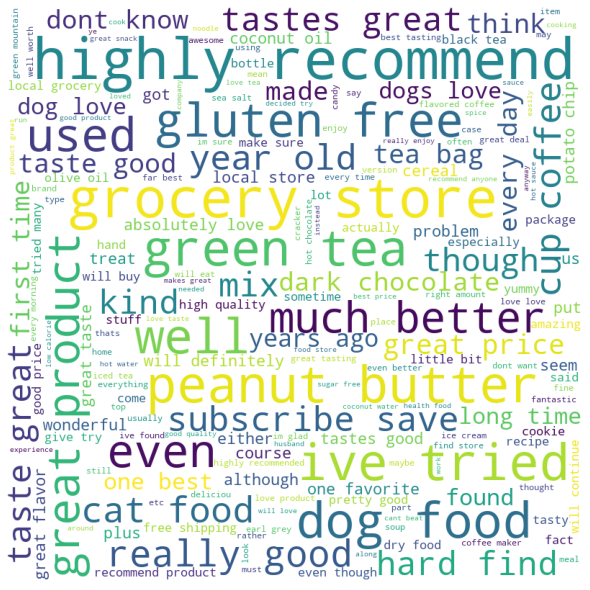

In [0]:
GetWordCloud(df.iloc[correct_ind_pos,-1].to_frame())

**Question 6.10:** What does the distribution of rating look like for correctly predicted positive reviews?

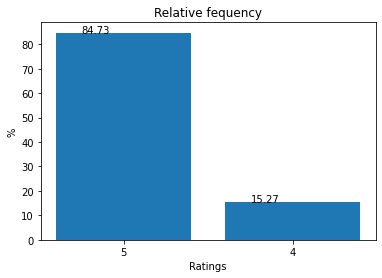

In [0]:
GetRelativeFrequency(df.iloc[correct_ind_pos,:])

**Question 6.11:** What does the correctly predicted negative reviews look like?

Again looking at the 3 randomly sampled negative reviews everything is working as expected.

In [0]:
GetSampleReviewsWithDetails(correct_ind_neg,3)

be aware that you will receive only jar not if you order this item the picture showing jars is misleading


Rating - 2 || Predicted Probability - 0.0657813549041748


i found this coffee to be great at first but as i started having it more and more i came to detest it on the large setting the coffee is way too watery also the flavor is very very overpowering and kind of tastes like bananasit is a pretty good midafternoon or evening desert coffee but other than that it is kinda gross


Rating - 1 || Predicted Probability - 0.01786443591117859


the taste is great but it gave me a terrible migraine from the msg those who are sensitive beware also msg addition is usually a way to fake true flavor


Rating - 1 || Predicted Probability - 0.03576955199241638




**Question 6.12:** What are the most popular words in correctly predicted  negative reviews?

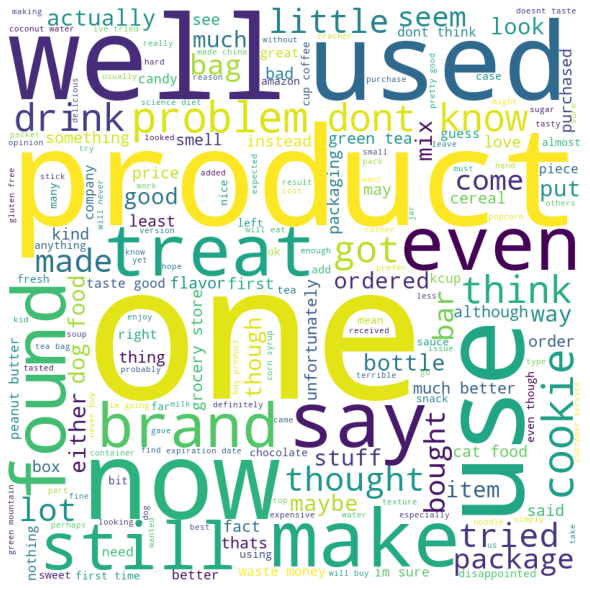

In [0]:
GetWordCloud(df.iloc[correct_ind_neg,-1].to_frame())

**Question 6.13:** What does the distribution of rating look like for incorrectly predicted positive reviews?

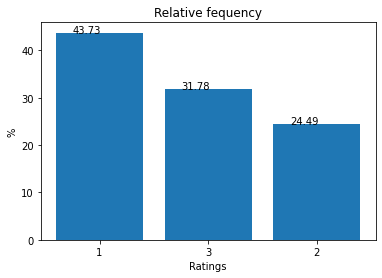

In [0]:
GetRelativeFrequency(df.iloc[correct_ind_neg,:])

**Question 6.14:** What does the incorrectly predicted positive reviews look like?

I've sampled 10 incorrectly predicted positive review and provided my labels(i.e. how I feel about the sentiment) on each of this review and if the model performance is explainable or satisfactory. Review # is the order in which the reviews are outputted in below cell


<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>4</td>
    <td>Positive</td>
    <td>Incoherent, Mixed Sentiments</td>
    <td>0.18</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>5</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.17</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.26</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.46</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>Positive</td>
    <td>Suggestions</td>
    <td>0.31</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>6</td>
    <td>5</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.08</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>7</td>
    <td>5</td>
    <td>Positive</td>
    <td>Suggestions</td>
    <td>0.43</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>8</td>
    <td>4</td>
    <td>Positive</td>
    <td>Positive Sentiments, Suggestions</td>
    <td>0.32</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>9</td>
    <td>5</td>
    <td>Positive</td>
    <td>Positive Sentiments</td>
    <td>0.18</td>
    <td>Not Satisfactory</td>
  </tr>
  <tr>
    <td>10</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.17</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
GetSampleReviewsWithDetails(incorrect_ind_pos,10)

 organic dark chocolate chips organic sugar organic chocolate liquor organic cocoa butter organic soy lecithin added as an emulsifier organic vanilla   from the ingredients list bobos oat bars chocolateseveral weeks ago i reviewed bobos oat bars all natural banana ounce packages pack of  to which i awarded four stars based on its excellent oat flavor and mouth feel however it suffered the loss of a fifth star because the ostensible banana taste was so subtle as to be virtually nonexistentbecause i love chocolate i decided to give bobo another shot with the chocolate version of her oat snackdark chocolate is on the bars ingredients list  as chips no less buts its a complete mystery to me where the essence of chocolate is lurking moreover there isnt a chocolate chip in sight i pulled the bar apart and examined it carefully granted the bar has a darker shade of color than the other ones of the brand ive tried so that at least implies chocolate is present and theres a faint nuance of some 

**Question 6.15:** What are the most popular words in incorrectly predicted  positive reviews?

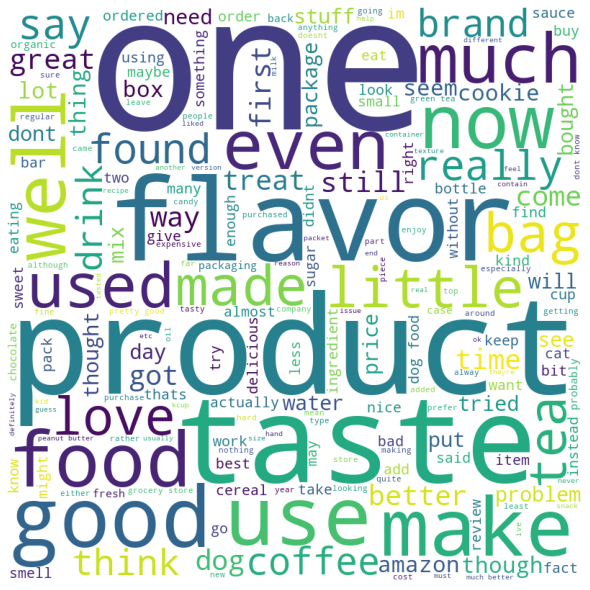

In [0]:
GetWordCloud(df.iloc[incorrect_ind_pos,-1].to_frame())

**Question 6.16:** What does the distribution of rating look like for incorrectly predicted positive reviews?

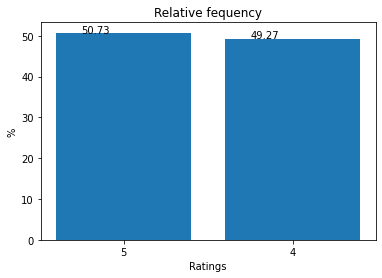

In [0]:
GetRelativeFrequency(df.iloc[incorrect_ind_pos,:])

**Question 6.17:** What does the incorrectly predicted negative reviews look like?

I've sampled 10 incorrectly predicted negative review and provided my labels(i.e. how I feel about the sentiment) on each of this review and if the model performance is explainable or satisfactory. Review # is the order in which the reviews are outputted in below cell, you can read the review there.

<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>3</td>
    <td>Negative</td>
    <td>Negative Sentiments, Criticism</td>
    <td>0.86</td>
    <td>Not Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>3</td>
    <td>Negative</td>
    <td>Mixed Sentiments, Edited Review</td>
    <td>0.56</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>3</td>
    <td>Negative</td>
    <td>Positive Sentiments, Usage Caution</td>
    <td>0.77</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>3</td>
    <td>Negative</td>
    <td>Positive Sentiments</td>
    <td>0.69</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>3</td>
    <td>Negative</td>
    <td>Postive Sentiments</td>
    <td>0.77</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>6</td>
    <td>3</td>
    <td>Negative</td>
    <td>Mixed Sentiments, Suggestion</td>
    <td>0.62</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>7</td>
    <td>3</td>
    <td>Negative</td>
    <td>Positive Sentiment, Negative Prediction</td>
    <td>0.88</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>8</td>
    <td>3</td>
    <td>Negative</td>
    <td>Positive Sentiments, Incoherent</td>
    <td>0.88</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>9</td>
    <td>2</td>
    <td>Negative</td>
    <td>Negative Sentiments, Positive Expectations</td>
    <td>0.69</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>10</td>
    <td>3</td>
    <td>Negative</td>
    <td>Positive Sentiments</td>
    <td>0.81</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
GetSampleReviewsWithDetails(incorrect_ind_neg,10)

this is one serving please stop trying to make it seem more healthful than it is it is very tasteful but is not as low fat as it seems to be trying to be when i cannot trust you whos next  colp


Rating - 3 || Predicted Probability - 0.8607024550437927


i like envirokidz crispy rice bars but these peanut choco ones are the best  they have actual bits of peanut mixed in which gives them a nice little crunch  one caveat  although these bars dont taste overly sweet they do have g of sugar each  health food theyre not  but they are a good substitute for candy bars which tend to be much higher in fat and sugaramazons price is the best ive found thus far especially if you do the subscribe  save optionlater edit  just downgraded my rating because the quality of the chocolate drizzle has really gone downhill  theyve also gotten gooier which i personally find unappealing


Rating - 3 || Predicted Probability - 0.5625847578048706


i have three geman shepherds and they love the chews  they have

**Question 6.18:** What are the most popular words in incorrectly predicted  negative reviews?

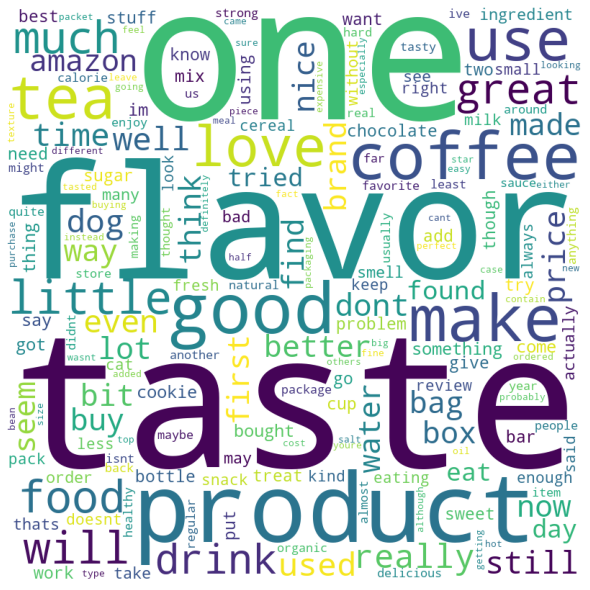

In [0]:
GetWordCloud(df.iloc[incorrect_ind_neg,-1].to_frame())

**Question 6.19:** What does the distribution of rating look like for incorrectly predicted negative reviews?

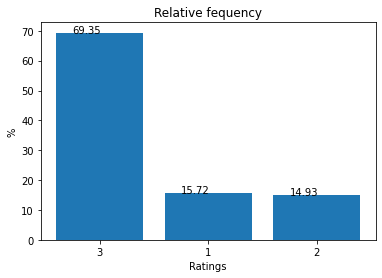

In [0]:
GetRelativeFrequency(df.iloc[incorrect_ind_neg,:])

**Question 6.20:** What does the distribution of predicted probablities  look like for incorrectly and correctly predicted positive reviews?



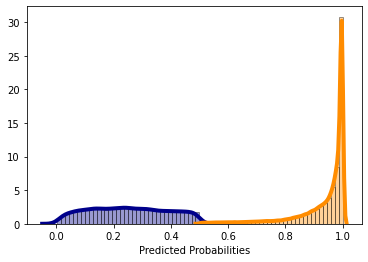

In [0]:
sns.distplot(pred[incorrect_ind_pos], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel = "Predicted Probabilities")

sns.distplot(pred[correct_ind_pos], hist=True, kde=True, 
             bins=int(180/5), color = 'darkorange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel = "Predicted Probabilities")

**Question 6.21:** What does the distribution of predicted probablities look like for incorrectly and correctly predicted negative reviews?



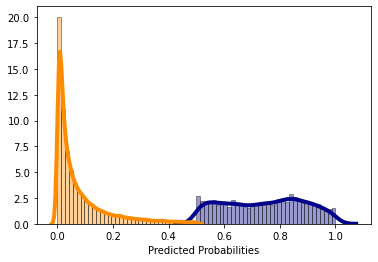

In [0]:
sns.distplot(pred[incorrect_ind_neg], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel = "Predicted Probabilities")

sns.distplot(pred[correct_ind_neg], hist=True, kde=True, 
             bins=int(180/5), color = 'darkorange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel = "Predicted Probabilities")

**Question 6.22:** What does the distribution of predicted probablities look like for different ratings?

<table>
  <tr>
    <th>Rating</th>
    <th>Comments</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Expectedly approximates exponential distribution with a sharp slope , nothing out of sorts.</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Expectedly approximates exponential distribution with a slightly less sharper slope, nothing out of sorts</td>
  </tr>
  <tr>
    <td>3</td>
    <td>In practical these are neutral reviews but for this analysis I set these up as negative reviews, it is likely the network <br/> shifted the neutral sentiments towards zero to help itself classify these as negative review. This is explained by a <br/> slightly less sharper drop in the slope, incomaprison with predicted probabilities for ratings 1 & 2. It is likely that <br/> neutral reviews with negative undertones ended up having probabilities close to zero and neutral reviews with mixed <br/> sentiments shifted from the 0.4 - 0.5 range to 0.10 -0.3 range and like wise neutral reviews with positive sentiments<br/> probably shifted from 0.5 - 0.65 range to 0.3 - 0.5 range. </td>
  </tr>
  <tr>
    <td>4</td>
    <td>Probability distribution of predicted probablities for rating 4 expectedly follows negative exponential distribution, but the <br/> slope of the curve isn't as sharp as I'd want to be. It should be noted  that around half of the wrongly predicted reviews were <br/> of rating 4, whereas proportion of reviews with rating 4 contributing to positive sentiments block was a mere ~21%. I </br> cannot hypothesize what could be the reason behind this until I go through a substantial chunk of rating 4 reviews with low <br/> predicted probability. </td>
  </tr>
  <tr>
    <td>5</td>
    <td>Expectedly approximates negative exponential distribution with a sharpe slope , nothing out of sorts</td>
  </tr>
</table>

Overall everything seems to be working fine except for reviews with Rating 4, the number of the incorrect reviews is highly disproportionate.

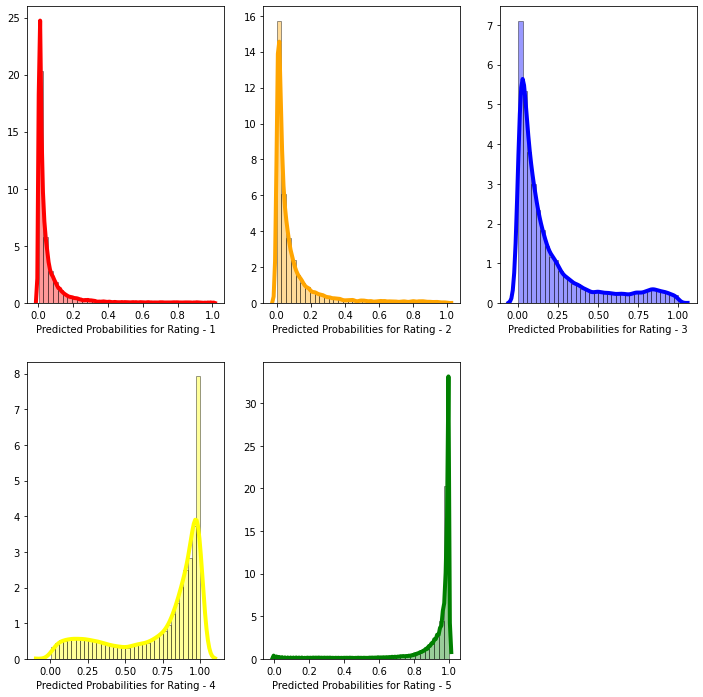

In [0]:
f, axes = plt.subplots(2, 3, figsize=(12, 12))
axes[1][2].set_axis_off()
for i,r,c in [[1, [0,0],"red"],[2, [0,1],"orange"],[3, [0,2],"blue"],[4, [1,0],"yellow"],[5, [1,1],"green"]]:
  sns.distplot(pred[df.Score == i], hist=True, kde=True, 
             bins=int(180/5), color = c, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel = f"Predicted Probabilities for Rating - {i}",
             ax=axes[r[0], r[1]])

**Question 6.22.1:** Are reviews with rating 4 have disproportionately high incorrect predictions ?

Yes.

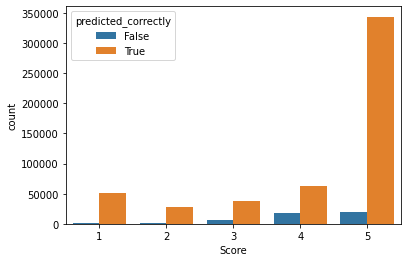

In [0]:
df["pred_prob"] = pred
df["predicted_correctly"] = pred_round == Y
sns.countplot(x = "Score", hue = "predicted_correctly", data = df)

**Question 6.22.2:** What does the review with rating 4 and predicted probability less than 0.11 look like ?

Sampling 5 reviews from the said distribution

<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Comparison</td>
    <td>0.04 (too low)</td>
    <td>Not Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>4</td>
    <td>Negative</td>
    <td>Mixed Sentiments, Suggestion, Expectations</td>
    <td>0.06</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>4</td>
    <td>Positive</td>
    <td>Negative Sentiments</td>
    <td>0.04</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>4</td>
    <td>Positive</td>
    <td>Negative Sentiments, Criticism</td>
    <td>0.08</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Negative Inclination</td>
    <td>0.015</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
index = list(df[(df.pred_prob < 0.11) & (df.Score == 4)].index)
GetSampleReviewsWithDetails(index,5, col_indices=[-3, -7])

i was surprised at how soft the cookie was i usually buy little debbies cookies and i noticed the quaker soft baked oatmeal cookie was bigger and had a bold taste


Rating - 4 || Predicted Probability - 0.10463613271713257


a while back i ordered bottles of the torani syrup i think it was the caramel and i really like the flavor but it is like water so be prepared when you start using it the only other thing i would like would be to be able to choose different flavors instead of all flavors being the same


Rating - 4 || Predicted Probability - 0.06538110971450806


i keep buying puzzle toys for my border collie mix with the hope of finally finding one that will take longer than minutes for him to figure out i had high hopes for the everlasting treat ball after reading so many good reviews however when i gave him the ball with the treat in it he popped the treat out in about minutes i tried flipping the treat over so it points in as suggested by other reviewers and that lasted another

**Question 6.22.3:** How are words distributed for reviews with rating 4 and predicted probability less than 0.11 ?

As explained above one can't read much from the word cloud but even a highre level presence of words such as "disappointed, prefer, hard, though" logically reconciles with the low predicted probability. 

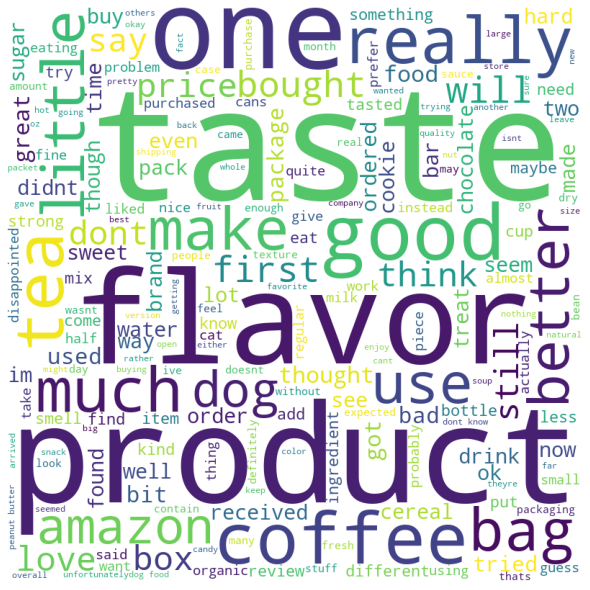

In [0]:
GetWordCloud(df[(df.pred_prob < 0.11) & (df.Score == 4)].seq_len_text.to_frame())

**Question 6.22.4:** What does the review with rating 4 and predicted probability between 0.11 - 0.21 look like ?

Sampling 5 reviews from the said distribution

<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>4</td>
    <td>Positive</td>
    <td>Negative Sentiments, Incoherent</td>
    <td>0.20</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>4</td>
    <td>Positive</td>
    <td>Negative Sentiments, Comparison</td>
    <td>0.15</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>4</td>
    <td>Negative</td>
    <td>Mixed Sentiments, Negative Inclination</td>
    <td>0.16</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Brief</td>
    <td>0.20</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>Positive</td>
    <td>Negative Sentiments</td>
    <td>0.13</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
index = list(df[(df.pred_prob >= 0.11) & (df.pred_prob < 0.21) & (df.Score == 4)].index)
GetSampleReviewsWithDetails(index,5, col_indices=[-3, -7])

not a really drinker dont keep booze in the house that said every once in a while i get in the mood for a libation always liked a long island iced tea but to make one requires buying a liquor stores worth of clears gave this a shot for like bucks in a big liter bottle totally on a whim when out to pick up a red wine for guests how awful could it be no worse than any of the other premade cocktails which is to say horrible ive had figured if it was terrible i could mix it


Rating - 4 || Predicted Probability - 0.2014760673046112


i love honey nut cheerios one of my favorite cereals of all time so i was intrigued by the new crunchy nut roasted nut and honey from kellogs i tried it first as dry cereal and was less than impressed the cereal is corn based so it had the aftertaste similar to corn pops cereal after the honey flavor wore off i believe cheerios are whole grain and oats so there is a very distinct taste differenceafter trying them with milk i am much more impressed with the cer

**Question 6.22.5:** How are words distributed for reviews with rating 4 and predicted probability between 0.11 - 0.21 ?

Nothing much to make sense of here, again advocating why it would be counter-productive to assign significant value to word counts in a sequence learning task.

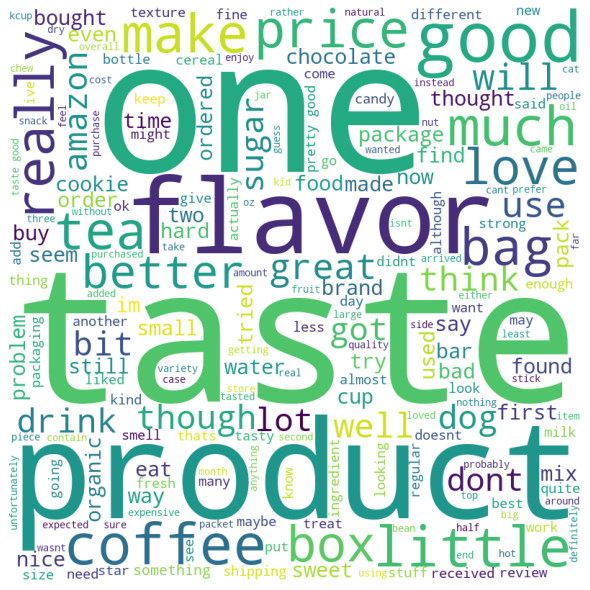

In [0]:
GetWordCloud(df[(df.pred_prob >= 0.11) & (df.pred_prob < 0.21) & (df.Score == 4)].seq_len_text.to_frame())

**Question 6.22.6:** What does the review with rating 4 and predicted probability between 0.21 - 0.31 look like ?

<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>4</td>
    <td>Positive</td>
    <td>Negative Sentiments</td>
    <td>0.26</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Caution</td>
    <td>0.15</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>4</td>
    <td>Negative</td>
    <td>Mixed Sentiments, Breif</td>
    <td>0.27</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Negative Inclination</td>
    <td>0.27</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.27</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
index = list(df[(df.pred_prob >= 0.21) & (df.pred_prob < 0.31) & (df.Score == 4)].index)
GetSampleReviewsWithDetails(index,5, col_indices=[-3, -7])

i absolutely love mallomars and they are hard to find especialy in california every once in a while one or two stores will have a limited supply so i was thrilled to find them on amazon and ordered right away thhey were good but a little stale i will ceratinly try again as they are a little additive ak


Rating - 4 || Predicted Probability - 0.2583104968070984


these are tasty and light but on the smallish side they are for sure meant as a snack not as a meal replacement the chocolatepeanut butter combination is great though nothing terribly different than a lot of products already out there to tell the truth i do like the the chocolate layer on the bottom it makes it seem more like a candy bar


Rating - 4 || Predicted Probability - 0.21824103593826294


good flavor but not real sweet i add a little stevia for my sweet tooth


Rating - 4 || Predicted Probability - 0.2726106643676758


like other reviewers already stated the directions for how much ho to add is waaaaay off following t

**Question 6.22.7:** How are words distributed for reviews with rating 4 and predicted probability between 0.21 - 0.31 ?

Slightly different from previous distribution.

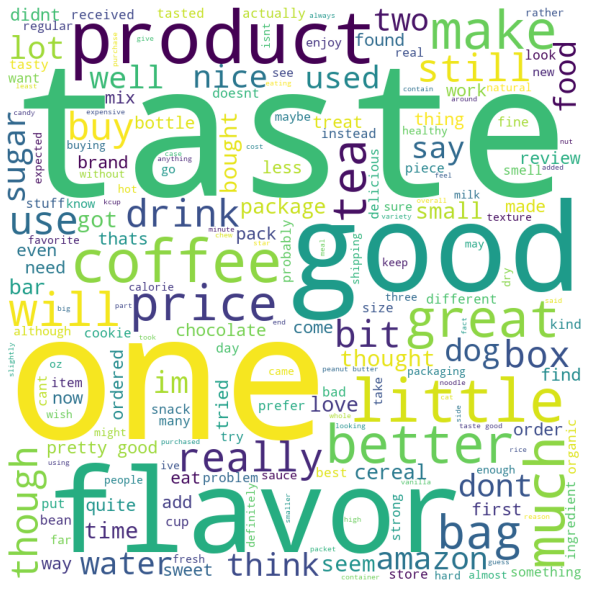

In [0]:
GetWordCloud(df[(df.pred_prob >= 0.21) & (df.pred_prob < 0.31) & (df.Score == 4)].seq_len_text.to_frame())

**Question 6.22.8:** What does the review with rating 4 and predicted probability between 0.31 - 0.41 look like ?

Sampling 5 reviews from the said distribution

<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Brief</td>
    <td>0.35</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>4</td>
    <td>Positive</td>
    <td>Positive Sentiments, Slight Incoherence</td>
    <td>0.34</td>
    <td>Not Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>4</td>
    <td>Negative</td>
    <td>Mixed Sentiments</td>
    <td>0.37</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Brief</td>
    <td>0.36</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>Positive</td>
    <td>Positive Sentiments, Suggestions</td>
    <td>0.39</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
index = list(df[(df.pred_prob >= 0.31) & (df.pred_prob < 0.41) & (df.Score == 4)].index)
GetSampleReviewsWithDetails(index,5, col_indices=[-3, -7])

not quite as tasty as the made in nature dried plums they are very good and a little less expensive


Rating - 4 || Predicted Probability - 0.35355478525161743


i absolutely am in love with these jelly babies do not hesitate at all to buy these jelly babies i purchased them just like everyone else i am a fan of doctor who and i was curious now i know why the fourth doctor was obsessed with them i have been ordering them one bag at a time now for a little bit the most recent time i decided to buy two bags it would have been a brilliant decision if it wasnt degrees out the day they were delivered needless to say my jelly babies were basically justjelly it


Rating - 4 || Predicted Probability - 0.34572815895080566


this is about as healthty as you can get when it comes to snacks i like to dip them in almond butter for some added protein i would rate them a five but like all the marys products they are fragile and you end up with too many small pieces in the bottom of the bag


Rating -

**Question 6.22.9:** How are words distributed for reviews with rating 4 and predicted probability between 0.31 - 0.41 ?

Not much different from previous distribution. Again not much useful.

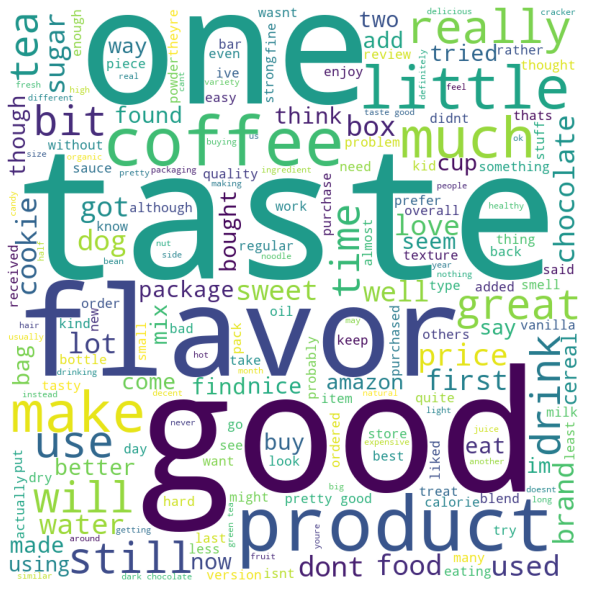

In [0]:
GetWordCloud(df[(df.pred_prob >= 0.31) & (df.pred_prob < 0.41) & (df.Score == 4)].seq_len_text.to_frame())

**Question 6.22.10:** What does the review with rating 4 and predicted probability between 0.41 - 0.50 look like ?

Sampling 5 reviews from the said distribution

<table>
  <tr>
    <th>#</td>
    <th>Rating</th>
    <th>Original Label</th>
    <th>My Label</th>
    <th>Predicted Probability</th>
    <th>Model Performance</th>
  </tr>
  <tr>
    <td>1</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Positive Inclination</td>
    <td>0.49</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>2</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Suggestions</td>
    <td>0.44</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>3</td>
    <td>4</td>
    <td>Negative</td>
    <td>Positive Sentiments, Suggestion, Brief</td>
    <td>0.45</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>4</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments, Positive Inclination</td>
    <td>0.43</td>
    <td>Satisfactory</td>
  </tr>
  <tr>
    <td>5</td>
    <td>4</td>
    <td>Positive</td>
    <td>Mixed Sentiments</td>
    <td>0.42</td>
    <td>Satisfactory</td>
  </tr>
</table>



In [0]:
index = list(df[(df.pred_prob >= 0.41) & (df.pred_prob < 0.50) & (df.Score == 4)].index)
GetSampleReviewsWithDetails(index,5, col_indices=[-3, -7])

mike and ike lovers have the chance to sample some exciting new fruit flavors in this special seasonal mummys mix box a combination of five fruit flavors in the same box lemon orange grape lime and raspberry fruit flavors are authentic with overall sweetness and just a touch of sourness to make your mouth water fresh and chewy we would have rated this stars but the fact that the box is not resealable is a negative factor but then maybe you are supposed to finish off all ounces while enjoying the movie with no need to seal the box closed


Rating - 4 || Predicted Probability - 0.49411576986312866


i got these because of their price primarily taste is great picks me up a bit but really doesnt do much i can drink two and not feel that jittery keep in mind i drink lots of caffeinated beverages so i have a tolerancei wish the extra strength came in packs of at this price that would be awesomethis is a great product but for a caffeine junkie like me its not up to snuff


Rating - 4 || Predi

**Question 6.22.11:** How are words distributed for reviews with rating 4 and predicted probability between 0.41 - 0.50 ?

Very similar to earlier distributions, hence not much useful

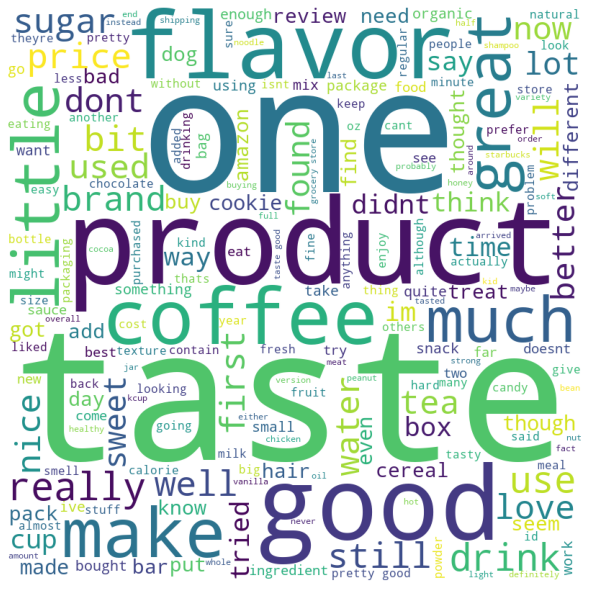

In [0]:
GetWordCloud(df[(df.pred_prob >= 0.41) & (df.pred_prob <= 0.50) & (df.Score == 4)].seq_len_text.to_frame())

**Question 6.23:** How satified am I with the model performance on the 25 sampled incorrectly predicted 4-star rating reviews ? 

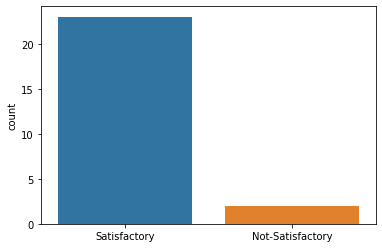

In [0]:
metric = ("Satisfactory " * 23).split()
metric.extend(("Not-Satisfactory " * 2).split())
sns.countplot(metric)

**Question 6.24:** How are my labels (i.e User Defined / adjudged)  distributed for the 25 sampled incorrectly predicted 4-star rating reviews ? 


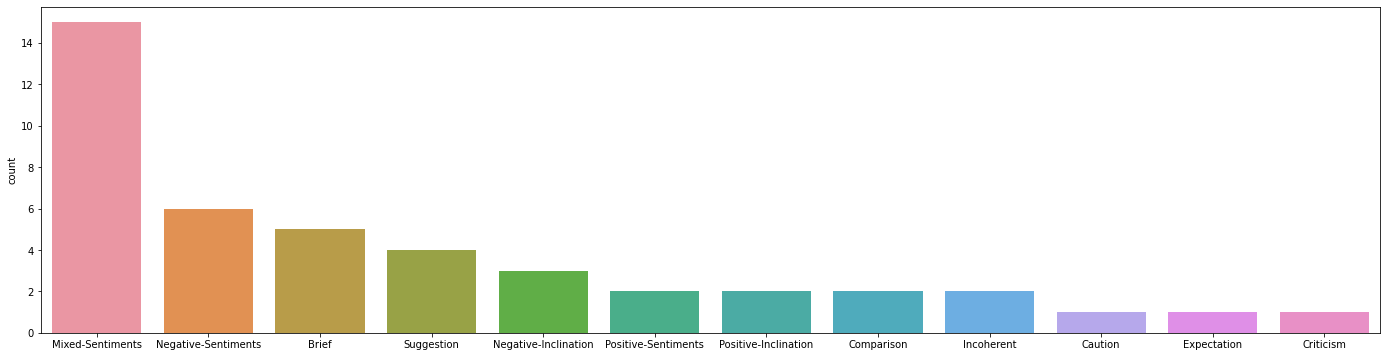

In [0]:
f, axes = plt.subplots(figsize=(24, 6))
labels = ("Mixed-Sentiments " * 15).split() #
labels.extend(("Negative-Sentiments " * 6).split()) #
labels.extend(("Brief " * 5).split()) #
labels.extend(("Suggestion " * 4).split()) #
labels.extend(("Negative-Inclination " * 3).split()) #
labels.extend(("Positive-Sentiments " * 2).split()) #
labels.extend(("Positive-Inclination " * 2).split()) #
labels.extend(("Comparison " *2).split()) #
labels.extend(("Incoherent " * 2).split()) #
labels.extend(("Caution " * 1).split()) #
labels.extend(("Expectation " * 1).split()) #
labels.extend(("Criticism " * 1).split()) #
sns.countplot(labels)

**Question 6.25:** Can I proceed with the model ?

The Analysis of 25 sampled incorrectly predicted reviews with ratings 4 suggests that model is doing well even where it's not expected to do well. Yes I should proceed with the model.

#7. Model Test

In this section I will test the model by tasking it with previously unseen data from the web.

In [0]:
# Converting reviews to network feedible format
def GetSingleSequence(sentence):
    sentence = sentence.lower()
    #Removing html tags
    sentence = re.compile(r'<[^>]+>').sub('', sentence)
    #Removing Punctuations
    sentence = re.sub(r'[^\w\s]','',sentence)
    words = sentence.split()[:seq_len]
    sequence = [[vocab[x].index] if x in vocab.keys() else [len(vocab)] for x in words]
    sequence = PadSequence(sequence)
    X = np.array(sequence).reshape(1,seq_len)
    return X

**Question 7.1:** How does the model perform on lengthy positive review with overwhelmingly positive sentiments?

***Review:***
These 1-min oats are a life saver. I love that it’s so practical to use. Usually in the morning I just pour in the amount I want and then add just some milk and put in microwave. While the coffee is brewing, it’ll be done at the time. I love that it doesn’t have any additives in it so I can add whatever I want depending on my mood. Some days I’ll add berries and banana, other days I’ll add chocolate chips and nuts or cinnamon and honey would do. I noticed that with a full bowl of these oats, my tummy is satisfied for longer so I cut down on eating unnecessary items in between. 

***Rating:*** 5

<a href="https://www.google.com/shopping/product/221584289841984714/reviews?q=quaker+oats&oq=quaker+oats+&aqs=chrome..69i57j0l6j46.10865j0j7&sourceid=chrome&ie=UTF-8">Source</a>

In [0]:
review = "These 1-min oats are a life saver. I love that it’s so practical to use. Usually in the morning I just pour in the amount I want and then add just some milk and put in microwave. While the coffee is brewing, it’ll be done at the time. I love that it doesn’t have any additives in it so I can add whatever I want depending on my mood. Some days I’ll add berries and banana, other days I’ll add chocolate chips and nuts or cinnamon and honey would do. I noticed that with a full bowl of these oats, my tummy is satisfied for longer so I cut down on eating unnecessary items in between."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Pretty Good !!! ")

0.9730412364006042 - Pretty Good !!! 


**Question 7.2:** How does the model perform on short positive review with overwhelmingly positive sentiments?

***Review:***
I CAN'T STOP EATING FLAMIN HOT CHEETOS, they're my weakness, idc the presentation, I love them in every way. They have the perfect spicy flavor.  

***Rating:*** 5

<a href="https://www.influenster.com/reviews/cheetos-crunchy-flamin-hot-cheese-flavored-snacks-49/42550327">Source</a>

In [0]:
review = "I CAN'T STOP EATING FLAMIN HOT CHEETOS, they're my weakness, idc the presentation, I love them in every way. They have the perfect spicy flavor. "
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Awesome !!! ")

0.994418740272522 - Awesome !!! 


**Question 7.3:** How does the model perform on medium length review with mixed sentiments?

***Review:***
"Love Cheerios, especially the frosted kind. Only reason for 4 stars instead of 5 is the sugar content. They don't really contain much nutritional value for a complete breakfast but they sure are tasty."

***Rating:*** 4

<a href="https://www.influenster.com/reviews/cheerios-general-mills-frosted-cereal/6822388">Source</a>

In [0]:
review = "Love Cheerios, especially the frosted kind. Only reason for 4 stars instead of 5 is the sugar content. They don't really contain much nutritional value for a complete breakfast but they sure are tasty."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Great !! ")

0.40862926840782166 - Consistent !! 


**Question 7.4:** How does the model perform on medium length review with mixed sentiments with negative inclination?

***Review:***

I tried these to compare with Frosted Flakes. They were just ok, I still prefer Honey Nut. Bought at Kroger and they did have several Cheerio choices. Will keep buying the honey nut and would suggest others to the same!

***Rating:*** 3

<a href="https://www.influenster.com/reviews/cheerios-general-mills-frosted-cereal/28820103">Source</a>

In [0]:
review = "I tried these to compare with Frosted Flakes. They were just ok, I still prefer Honey Nut. Bought at Kroger and they did have several Cheerio choices. Will keep buying the honey nut and would suggest others to the same!"
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Good !! ")

0.0421736016869545 - Good !! 


**Question 7.5:** How does the model perform on lengthy review with overwhelmingly Negative sentiments?

***Review:***
These are wayyy too sugary for me. With all the added sugars, I don't really think these can even still be considered healthy. But since it's under the Cheerios name, many will just associate this with a healthy morning option. Definitely not a great start to your day, unless you were planning on working a sugar crash into your busy schedule. I never actually buy this cereal directly, I always end up getting it when I purchase those mini cereal variety boxes, and then I eat it at 2 a.m. when I am truly desperate for a snack. 
These are wayyy too sugary for me. With all the added sugars, I don't really think these can even still be considered healthy. But since it's under the Cheerios name, many will just associate this with a healthy morning option. Definitely not a great start to your day, unless you were planning on working a sugar crash into your busy schedule. I never actually buy this cereal directly, I always end up getting it when I purchase those mini cereal variety boxes, and then I eat it at 2 a.m. when I am truly desperate for a snack. 
 

***Rating:*** 2

<a href="https://www.google.com/shopping/product/221584289841984714/reviews?q=quaker+oats&oq=quaker+oats+&aqs=chrome..69i57j0l6j46.10865j0j7&sourceid=chrome&ie=UTF-8">Source</a>

In [0]:
review = "These are wayyy too sugary for me. With all the added sugars, I don't really think these can even still be considered healthy. But since it's under the Cheerios name, many will just associate this with a healthy morning option. Definitely not a great start to your day, unless you were planning on working a sugar crash into your busy schedule. I never actually buy this cereal directly, I always end up getting it when I purchase those mini cereal variety boxes, and then I eat it at 2 a.m. when I am truly desperate for a snack. These are wayyy too sugary for me. With all the added sugars, I don't really think these can even still be considered healthy. But since it's under the Cheerios name, many will just associate this with a healthy morning option. Definitely not a great start to your day, unless you were planning on working a sugar crash into your busy schedule. I never actually buy this cereal directly, I always end up getting it when I purchase those mini cereal variety boxes, and then I eat it at 2 a.m. when I am truly desperate for a snack."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Pretty Good !!! ")

0.08640038222074509 - Pretty Good !!! 


**Question 7.6:** How does the model perform on short negative review with overwhelmingly negative sentiments?

***Review:***
"I don't think these are good at all. Someone recommend these to me to try. I will not buy these ever.."

***Rating:*** 1

<a href="https://www.influenster.com/reviews/cheerios-general-mills-frosted-cereal/12299650">Source</a>

In [0]:
review = "I don't think these are good at all. Someone recommend these to me to try. I will not buy these ever.."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Excellent !!! ")

0.02735918201506138 - Excellent !!! 


#8. Transfer Learning

In this section I am exploring the possibility of using learned weights from the model to predict sentiments in different problem domains. 

##8.1 Restaurant Reviews

**Question 8.1.1:** How does the model perform on positive review ?

***Review:*** I love to treat myself for lunch here! Sandwiches are 5.99, drinks 1, combo 9.99 and that includes two sides and a drink (pop or juice). It's also delicious and the staff are kind. I almost always get a combo with potatoes, salad and the falafel wrap. It's very filling! The potatoes are roasted and seasoned wonderfully and they can put a creamy garlic sauce over them. The salad is spiced with vinegar and roasted thyme. YUM! The falafel is perfect! Crunchy outside, soft inside, seasoned, it's great. The rice is the only thing I'm not excited about. It doesn't have as strong a flavor as I would like but if you like a blander taste you will probably enjoy it. Overall, very affordable and at a great cost. I could not recommend this place more.

***Rating:*** 5

*Source* - 
<span class="yelp-review" data-review-id="H1yetnx1QX8YQCYL99c4Bg" data-hostname="www.yelp.com">Read <a href="https://www.yelp.com/user_details?userid=xkCwSztKycwuvkub9A_fjA" rel="nofollow noopener">Fushcia H.</a>'s <a href="https://www.yelp.com/biz/al-madina-market-and-grill-cincinnati?hrid=H1yetnx1QX8YQCYL99c4Bg" rel="nofollow noopener">review</a> of <a href="https://www.yelp.com/biz/jamf4zugTAN68MRjq8F_8Q" rel="nofollow noopener">Al-Madina Market & Grill</a> on <a href="https://www.yelp.com" rel="nofollow noopener">Yelp</a><script async="async" src="https://www.yelp.com/embed/widgets.js" type="text/javascript"></script></span>

In [0]:
review = "I love to treat myself for lunch here! Sandwiches are 5.99, drinks 1, combo 9.99 and that includes two sides and a drink (pop or juice). It's also delicious and the staff are kind. I almost always get a combo with potatoes, salad and the falafel wrap. It's very filling! The potatoes are roasted and seasoned wonderfully and they can put a creamy garlic sauce over them. The salad is spiced with vinegar and roasted thyme. YUM! The falafel is perfect! Crunchy outside, soft inside, seasoned, it's great. The rice is the only thing I'm not excited about. It doesn't have as strong a flavor as I would like but if you like a blander taste you will probably enjoy it. Overall, very affordable and at a great cost. I could not recommend this place more."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Awesome like Al-Madina!!! ")

0.9842723608016968 - Awesome like Al-Madina!!! 


**Question 8.1.2:** How does the model perform on negative review ?

***Review:*** Extremely poor service. They have no servers. They take an order and don't even bring it. So you are left with no food on the table.  
We were there today and ordered for bhindi masala and hariyali kofta and Naan. The haryali kofta came in with naan, We had to remind the server twice to bring in the rice.Then we were waiting for the bhindi masala to be brought to the table. In the mean while the other orders were being brought out and no sign of our second entree. We kept reminding them about the order and all we got was yes it is getting ready. By the third reminder I was so upset and told him he should cancel the bhindi masala order as we were almost done eating. The nerve he had to tell us "oh we are just bringing it out". I was really upset about it, we had waited for almost 30 mins for the bhindi masala.
We just finished our one entree and left, there was no sorry nothing from the person taking the bills. That's pretty rude.
Don't know how long this restaurant can function with this kind of service.
Would like to put Zero stars for this like of service.

***Rating:*** 1

*Source* - 
<span class="yelp-review" data-review-id="jETzCDaVkhoHJnPmi8AjoQ" data-hostname="www.yelp.com">Read <a href="https://www.yelp.com/user_details?userid=672O44ba3n87ZSw1vHReSA" rel="nofollow noopener">Avisha G.</a>'s <a href="https://www.yelp.com/biz/ravis-hyderabad-house-cincinnati?hrid=jETzCDaVkhoHJnPmi8AjoQ" rel="nofollow noopener">review</a> of <a href="https://www.yelp.com/biz/lGs4EZmt-aoiSFfM09tbCg" rel="nofollow noopener">Ravis Hyderabad House</a> on <a href="https://www.yelp.com" rel="nofollow noopener">Yelp</a><script async="async" src="https://www.yelp.com/embed/widgets.js" type="text/javascript"></script></span>

In [0]:
review = "Extremely poor service. They have no servers. They take an order and don't even bring it. So you are left with no food on the table. We were there today and ordered for bhindi masala and hariyali kofta and Naan. The haryali kofta came in with naan, We had to remind the server twice to bring in the rice.Then we were waiting for the bhindi masala to be brought to the table. In the mean while the other orders were being brought out and no sign of our second entree. We kept reminding them about the order and all we got was yes it is getting ready. By the third reminder I was so upset and told him he should cancel the bhindi masala order as we were almost done eating. The nerve he had to tell us oh we are just bringing it out. I was really upset about it, we had waited for almost 30 mins for the bhindi masala. We just finished our one entree and left, there was no sorry nothing from the person taking the bills. That's pretty rude. Don't know how long this restaurant can function with this kind of service. Would like to put Zero stars for this like of service."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Decent ! ")

0.24379348754882812 - Decent ! 


##8.2 Movie / Series Reviews

**Question 8.2.1:** How does the model perform on positive review ?

***Review:*** A glorious train wreck that will not let you look away! You should be inside already, sit back and enjoy the show!

***Rating:*** 5

*Source* - <a href="https://www.rottentomatoes.com/tv/tiger_king/s01/reviews?type=user"> Review by Tom A at Rotten Tomatoes </a>

In [0]:
review = "A glorious train wreck that will not let you look away! You should be inside already, sit back and enjoy the show!"
print(f"{model.predict(GetSingleSequence(review))[0][0]} - 5 stars for the prediction. Roar!!! ")

0.8505125641822815 - 5 stars for the prediction. Roar!!! 


**Question 8.2.2:** How does the model perform on negative review ?

***Review:*** Season 8 of Game of Thrones had some of the laziest writing I have ever seen. The writers abandoned every storyline, character storylines/arcs, and reverse engineered everything to get their mad queen narrative. Season 8 quite simply, was an insult to viewers and GOT fans everywhere.


***Rating:*** 0.5


*Source* - <a href="https://www.rottentomatoes.com/tv/game_of_thrones/s08#audience_reviews"> Review by Jess C at Rotten Tomatoes </a>

In [0]:
review = "Season 8 of Game of Thrones had some of the laziest writing I have ever seen. The writers abandoned every storyline, character storylines/arcs, and reverse engineered everything to get their mad queen narrative. Season 8 quite simply, was an insult to viewers and GOT fans everywhere."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Avearge, Just like GOT Season 8 ! ")

0.3890485167503357 - Avearge, Just like GOT Season 8 ! 


##8.3 Tweets

**Question 8.3.1:** How does the model perform on positive tweet ?

***Tweet:***

We hope you have a great weekend.

We hope you stay at home.

We hope you stay away from gatherings and practice physical distancing.

We  hope you decide to protect others, protect our community.

We hope you take #COVID19 seriously.

 #InThisTogether


*Source* - <a href="https://twitter.com/WRPSToday/status/1246155454880845824"> Twitter </a>

In [0]:
review = "We hope you have a great weekend. We hope you stay at home. We hope you stay away from gatherings and practice physical distancing. We hope you decide to protect others, protect our community. We hope you take #COVID19 seriously. #InThisTogether"
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Positive!! ")

0.72294020652771 - Positive!! 


**Question 8.3.2:** How does the model perform on negative tweet ?

***Tweet:*** 

@airtelindia
 
@Airtel_Presence
  Call back from network team is complete lie. They give a single ring missed call and say they could reach us.

Network provider cannot reach customer on their own network lol. Irony



*Source* - <a href="https://twitter.com/hbchetanjain/status/1246064598987366400"> Twitter </a>

In [0]:
review = "Call back from network team is complete lie. They give a single ring missed call and say they could reach us. Network provider cannot reach customer on their own network lol. Irony"
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Spot On !!! ")

0.04222555086016655 - Spot On !!! 


##8.4 Sports Reactions/Comments

**Question 8.4.1:** How does the model perform on positive comment ?

***Comment:***

He’s hugely popular in the squad and his outlook and fun-loving nature generates a sense of collective well-being and togetherness. I know social media isn’t a true barometer of anything, but look at the way he interacts with other players on Instagram and how they respond. It’s not just his so-called mates either, it’s senior players and young players, right throughout the squad.

Source: <a href="https://arseblog.com/2019/09/why-pierre-emerick-aubameyang-should-be-named-arsenal-captain/"> Arseblog </a>

In [0]:
review = "He’s hugely popular in the squad and his outlook and fun-loving nature generates a sense of collective well-being and togetherness. I know social media isn’t a true barometer of anything, but look at the way he interacts with other players on Instagram and how they respond. It’s not just his so-called mates either, it’s senior players and young players, right throughout the squad."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Decent! ")

0.6613869667053223 - Decent! 


**Question 8.4.2:** How does the model perform on negative comment ?

***Comment:*** 

The issues were endless. Fractious relationships with players; Ozil and Ramsey left out then brought back; a lack of genuine authority despite trying to be an authoritarian when he first took over; no defined style of play; our captain basically destroying his own legacy to get away from the club as quickly as possible this summer (more alarm bells); the indecision over simple things like who should be captain; the Xhaka situation for which the player deserves criticism for his reaction, but under which Emery had lit a fuse that never needed to be lit with his handling of the captaincy; poor communication, and clumsy attempts to connect with fans who had long lost faith; there was just so much in 18 months that it had to come to head.


Source: <a href="https://arseblog.com/2019/11/unai-emery-arsenal-head-coach-23-05-18-29-11-2019/"> Arseblog </a>

In [0]:
review = "The issues were endless. Fractious relationships with players; Ozil and Ramsey left out then brought back; a lack of genuine authority despite trying to be an authoritarian when he first took over; no defined style of play; our captain basically destroying his own legacy to get away from the club as quickly as possible this summer (more alarm bells); the indecision over simple things like who should be captain; the Xhaka situation for which the player deserves criticism for his reaction, but under which Emery had lit a fuse that never needed to be lit with his handling of the captaincy; poor communication, and clumsy attempts to connect with fans who had long lost faith; there was just so much in 18 months that it had to come to head."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Great !! ")

0.1975400149822235 - Great !! 


## 8.5 Are there any examples where the model is not performing well ?

**8.5.1: Criticising the critics**

**Review:**

This movie should not be rated by any "critic" this show has a following that spans millions and millions of fans. As a true fan of this show and these guys, I rate it a popping 5 Stars.. The movie was excellent all around. It's just sad to see some guy who probably sat and watched this movie with Oscar Award goggles on. Hahahahahahahahaha... now that was funny.


**My Label:** Positive Review with criticism for critics

**Rating:** 5

**Model Performance:** Although objectively overall sentiment of the statement is mixed but with respect to movie the sentiment is clearly positive, the model is not taking into account the context specific positivity and instead has a generalized approach to sentiments of the statement.

<a href="rottentomatoes.com">Source</a>

In [0]:
review = "This movie should not be rated by any critic this show has a following that spans millions and millions of fans. As a true fan of this show and these guys, I rate it a popping 5 Stars.. The movie was excellent all around. It's just sad to see some guy who probably sat and watched this movie with Oscar Award goggles on. Hahahahahahahahaha... now that was funny."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Confused !! ")

0.3304857313632965 - Confused !! 


**8.5.2: Sarcasm**

**Review:**

God Himself could not record as good a greatest hits album like this, and if He were to listen to all 17 tracks on this compilation, He would refrain from striking me down for blasphemy. The song “Hot Shot City” is particularly good.


**My Label:** Negative


**Model Performance:** It would be too much to expect the model to understand the sarcasm, especially when text are not accompanied by pauses and tonal modulations. May be in a parallel universe where everyone reviews like Chandler Bing, this model would still likely give same results ;).

<a href="https://www.dailyedge.ie/funny-amazon-reviews-2-1039869-Aug2013/">Source</a>

In [0]:
review = "God Himself could not record as good a greatest hits album like this, and if He were to listen to all 17 tracks on this compilation, He would refrain from striking me down for blasphemy. The song “Hot Shot City” is particularly good."
print(f"{model.predict(GetSingleSequence(review))[0][0]} - Bazinga !!! ")

0.9112076759338379 - Bazinga !!! 


#9. Results


##9.1 Summary
From the analysis, it is quite evident that the model developed is well-equipped to appropriately classify the reviews based on its sentiments. 

Initially, I started with setting up the dataset in my google drive, as colab doesn't hold datasets in the environment for too long and each time the runtime gets disconnected (which is quite often) I would need to upload the dataset. I then performed EDA on it if there's something that is statistically deceptive in the dataset.

I then cleaned data of any punctuations and html tags. Converted the data into a binary classification problem, where reviews with rating (or score) 1,2 & 3 were labeled as negative sentiments (or 0) and reviews with rating 4 & 5 were labeled as positive sentiments (or 1).

I then fed the data to the Word2Vec method from the Gensim library. Gensim word2vec model then returned a word vector object containing contextualized embedding matrix, vocabs, index2words..etc. I then use the vocab and set up the training data and labels into a network feedable format.

In the next section, I iteratively developed a Recurrent Neural Network model using the super-easy Keras wrapper of the TensorFlow framework. I also assigned appropriate weights to each class to account for the massive class imbalance. After finalizing the model I then analyzed the performance. Overall the model seemed to be doing pretty well (i.e 90% train and validation accuracy), but after careful analysis, it was evident that the model does seem to be doing well on all types of reviews with exception of reviews with rating 4.

Reviews with rating 4 were found to have disproportionately high number of reviews to be incorrectly predicted as negative, but a detailed analysis on samples from different probability distribution revealed that although most of the reviews had rating 4, the overwhelming sentiments in the reviews were either mixed or negative, hence the incorrect prediction in terms of rating. But with respect to sentiments of these reviews, the incorrect prediction actually made more sense.

An explanation why reviews with rating 4 either had negative or mixed sentiments can be that, generally, when people review something they've 2 approaches the bottom-up approach (i.e 0 to 5), where the reviewer starts from zero and keeps adding points incrementally, and the opposite top-down approach (i.e 5 to 0), where one assigns full points to a product and then decreases the points with each failure in the sequential assessment of the product. The fact that the network could learn the second type of reviews without being explictly told (i.e no labels were provided of such nature) shows the immense power of LSTM (Long Short Term Memory) cells and RNN architecture, and it also reminded me of a popular blog post by Andrei Karpathy about <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a>.

Further, I validated the model with previously unseen data from the web, and the model performed as expected. I then tried to predict sentiments on statements or reviews from other domains by pooling in data from different sources, to see if the weights learned can be used for the other tasks as well, and the results were promising. 

Although I cannot claim that the learned weights alone can suffice to predict the sentiments from different domains, but certainly one can transfer the learning from one task to another task, given that tasks are of similar nature, and on top of the learned weights one can have a small network of its own which is adept at classifying sentiments for that domain, thereby greatly reducing the time taken for training.


##9.2 Key Results

1. Model finalized was a RNN model (LSTM Cells).
2. Model had an initial train and validation accuracy of 90%.
3. Model had Sensitivity of 91.44%, Specificity of 93.56% and precision equal to 98.06%.
4. Upon detailed analysis of the errors, model accuracy and learning was found to be higher than the earlier assessment. 
5. Model is close to the desired Low Bias Low Variance sub-section.
6. Learned weights can be successfully used to learn sentiments for similar tasks in different problem areas through transfer learning.
7. RNN Architecture (including the LSTM cell) is extremely powerful at dealing with sequence learning problems, especially more so when it comes to Natural Language Processing.

##9.3 Application

There can be many ways to apply this model, but one application that right away comes to mind is, maybe a company which sells food products can set up web crawlers, which would go out and crawl information about its product from various social media platforms (like Twitter, Facebook, Linkedin..etc), the model then automatically classifies the sentiment of that statement and this can be broadly used to check overall how the product is being received on a daily, weekly or monthly basis, and based on the results, further analysis can be commissioned for various sub-groups.

##9.4 Future Works

As far as the classifier is concerned the scope for improvement is less, any significant improvement would require a lengthy process of iteration. However, it would be very useful if I can deploy this model, have it predict the sentiments on various newly generated data and get a sampled and customized report on a daily basis to check if the model is indeed performing as hypothesized by the analysis.

#10. Acknowledgements
<a id="ack"></a>
1. Some of the analysis was completed using [Kaggle Kernels](https://https://www.kaggle.com/nifaullah/amazon-food-reviews-analysis/edit).
2. This analysis was later transferred to <a href="https://colab.research.google.com/notebooks/intro.ipynb">Google Colab</a> due to environment issues
3. J. McAuley and J. Leskovec. <a href="http://i.stanford.edu/~julian/pdfs/www13.pdf">From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews.</a> WWW, 2013.